We want payoff function 
$$payoff = \max\{x_1 - x_2 -\kappa, 0\}

# Distribution

In [1]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3
num_qubits_for_each_dimension = num_uncertainty_qubits + 1

# # parameters for considered random distribution
# T = 40 / 365  # 40 days to maturity

# # first variable
# S1 = 2.0 # initial spot price
# vol1 = 0.4  # volatility of 40%
# r1 = 0.04  # annual interest rate of 4%

# # resulting parameters for log-normal distribution
# mu1 = (r1 - 0.5 * vol1**2) * T + np.log(S1)
# sigma1 = vol1 * np.sqrt(T)
# mean1 = np.exp(mu1 + sigma1**2 / 2)
# variance1 = (np.exp(sigma1**2) - 1) * np.exp(2 * mu1 + sigma1**2)
# stddev1 = np.sqrt(variance1)

# # second variable
# S2 = 1.8 # initial spot price
# vol2 = 0.3  # volatility of 30%
# r2 = 0.05  # annual interest rate of 5%

# # resulting parameters for log-normal distribution
# mu2 = (r2 - 0.5 * vol2**2) * T + np.log(S2)
# sigma2 = vol2 * np.sqrt(T)
# mean2 = np.exp(mu2 + sigma2**2 / 2)
# variance2 = (np.exp(sigma2**2) - 1) * np.exp(2 * mu2 + sigma2**2)
# stddev2 = np.sqrt(variance2)

# # lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
# # low = np.maximum(0, mean - 3 * stddev)
# low = 0
# high = max(mean1 + 3 * stddev1, mean2 + 3 * stddev2)

# # map to higher dimensional distribution
# # for simplicity assuming dimensions are independent and identically distributed)
# dimension = 2
# num_qubits = [num_uncertainty_qubits] * dimension
# low = low * np.ones(dimension)
# high = high * np.ones(dimension)
# mu = [mu1, mu2]
# cov = np.diag([sigma1**2, sigma2**2]) # covariance matrix


# parameters for considered random distribution
S = 0.5  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)



# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = 0
high = mean + 3 * stddev

print("mu: {}".format(mu))
print("sigma: {}".format(sigma))

print("lower bound: {}".format(low))
print("upper bound: {}".format(high))


# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix


# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

mu: -0.6975307422037809
sigma: 0.13241694217637887
lower bound: 0
upper bound: 0.7025723177176686


In [2]:
u.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘

{'011 110': 1, '111 100': 4, '011 101': 1, '110 111': 4, '100 111': 8, '110 101': 98, '111 101': 11, '111 110': 2, '100 101': 114, '110 110': 39, '100 100': 49, '101 110': 105, '110 100': 37, '101 111': 5, '101 100': 147, '101 101': 348, '100 110': 27}


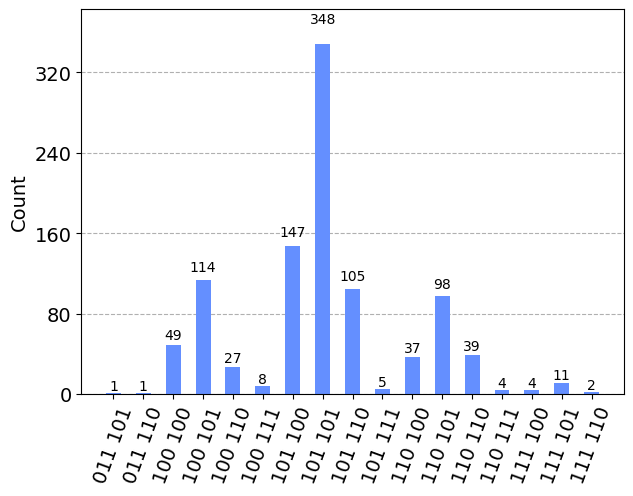

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
first_number_register = QuantumRegister(num_uncertainty_qubits, name='number1')
second_number_register = QuantumRegister(num_uncertainty_qubits, name='number2')
first_number_results = ClassicalRegister(num_uncertainty_qubits, name='classical1')
second_number_results = ClassicalRegister(num_uncertainty_qubits, name='classical2')

quantum_circuit = QuantumCircuit(first_number_register, second_number_register, first_number_results, second_number_results)
quantum_circuit.append(u, first_number_register[:] + second_number_register[:])
quantum_circuit.measure(first_number_register, first_number_results)
quantum_circuit.measure(second_number_register, second_number_results)

job = execute(quantum_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

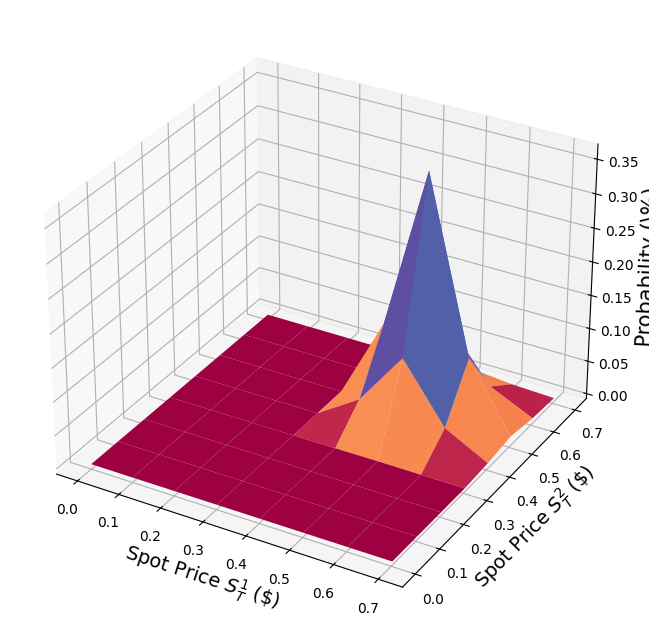

In [4]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=14)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=14)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.circuit.library import VBERippleCarryAdder

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
carryRegister = QuantumRegister(1, 'carry')
ancillaRegister = QuantumRegister(num_qubits_for_each_dimension, 'ancilla')

adder = VBERippleCarryAdder(num_qubits_for_each_dimension, name="Adder")
num_qubits = len(adder.qubits)

circ = QuantumCircuit(carryRegister, firstRegister, secondRegister, ancillaRegister, name="subtractor")
circ.x(secondRegister)
circ.x(carryRegister)
circ.append(adder, list(range(num_qubits)))
circ.draw()



┌───┐┌─────────┐
    carry: ┤ X ├┤0        ├
           └───┘│         │
  first_0: ─────┤1        ├
                │         │
  first_1: ─────┤2        ├
                │         │
  first_2: ─────┤3        ├
                │         │
  first_3: ─────┤4        ├
           ┌───┐│         │
 second_0: ┤ X ├┤5        ├
           ├───┤│         │
 second_1: ┤ X ├┤6  Adder ├
           ├───┤│         │
 second_2: ┤ X ├┤7        ├
           ├───┤│         │
 second_3: ┤ X ├┤8        ├
           └───┘│         │
ancilla_0: ─────┤9        ├
                │         │
ancilla_1: ─────┤10       ├
                │         │
ancilla_2: ─────┤11       ├
                │         │
ancilla_3: ─────┤12       ├
                └─────────┘

In [94]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 0.05

# map strike price from [low, high] to {0, ..., 2^n-1}
max_value = 2**(num_qubits_for_each_dimension) -1
low_ = low[0]
high_ = high[0]
mapped_strike_price = (
    (strike_price - low_) / (high_ - low_) * (2**(num_qubits_for_each_dimension) - 1)) + 2**(num_uncertainty_qubits)-1

mapped_strike_price = 8+ strike_price/high_*0
print("original range: {}".format([low_, high_]))
print("qubit value range: {}".format([0, max_value]))
print("strike price: {}".format(strike_price))  
print("mapped strike price: {}".format(mapped_strike_price))
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [0, mapped_strike_price]
slopes = [0, 1]
offsets = [0, 0]

f_min = 0
f_max = max_value - mapped_strike_price
print("payoff function range: {}".format([0, f_max]))

spread_objective = LinearAmplitudeFunction(
    num_qubits_for_each_dimension,
    slopes,
    offsets,
    domain=(0, max_value),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

# spread_objective.num_ancillas


original range: [0.0, 0.7025723177176686]
qubit value range: [0, 15]
strike price: 0.05
mapped strike price: 8.0
payoff function range: [0, 7.0]


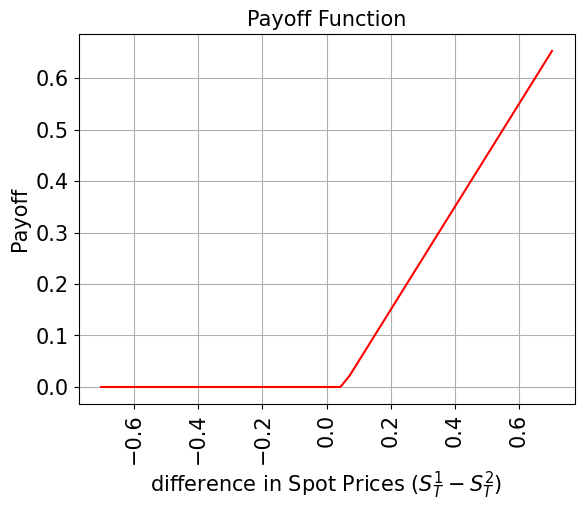

In [95]:
import matplotlib.pyplot as plt
x = np.linspace(low[0]-high[0], high[0])
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "r-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("difference in Spot Prices ($S_T^1 - S_T^2)$", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [96]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit, ClassicalRegister
# define overall multivariate problem

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
objectiveRegister = QuantumRegister(1, 'obj')
carryRegister = QuantumRegister(1, 'carry')
ancillaRegister = AncillaRegister(max(num_qubits_for_each_dimension, spread_objective.num_ancillas), 'ancilla')
# first_number_register = ClassicalRegister(num_qubits_for_each_dimension, 'first_number')
second_number_register = ClassicalRegister(num_qubits_for_each_dimension, 'second_number')
# optionAncillaRegister = AncillaRegister(spread_objective.num_ancillas, 'optionAncilla')
def swap_all(n):
    """Creates a circuit that swaps all qubits"""
    circuit = QuantumCircuit(n, name='SWAP_ALL')
    for i in range(n//2):
        circuit.swap(i, n-i-1)
    return circuit


spread_option = QuantumCircuit(carryRegister, firstRegister, secondRegister, ancillaRegister, objectiveRegister, second_number_register)
spread_option.append(u, firstRegister[:-1] + secondRegister[:-1])
spread_option.append(circ, carryRegister[:] + firstRegister[:]+ secondRegister[:] + ancillaRegister[:])
# spread_option.measure(firstRegister, first_number_register)
spread_option.x(secondRegister[-1])
spread_option.measure(secondRegister, second_number_register)
spread_option.draw()


┌──────────────┐                 
          carry: ─────────┤0             ├─────────────────
                 ┌───────┐│              │                 
        first_0: ┤0      ├┤1             ├─────────────────
                 │       ││              │                 
        first_1: ┤1      ├┤2             ├─────────────────
                 │       ││              │                 
        first_2: ┤2      ├┤3             ├─────────────────
                 │       ││              │                 
        first_3: ┤  P(X) ├┤4             ├─────────────────
                 │       ││              │     ┌─┐         
       second_0: ┤3      ├┤5             ├─────┤M├─────────
                 │       ││              │     └╥┘┌─┐      
       second_1: ┤4      ├┤6  subtractor ├──────╫─┤M├──────
                 │       ││              │      ║ └╥┘┌─┐   
       second_2: ┤5      ├┤7             ├──────╫──╫─┤M├───
                 └───────┘│              │┌───┐ ║  ║ └╥┘┌─┐
       second_3: ─────────┤8             ├┤ X ├─╫──╫──╫─┤M├
                          │              │└───┘ ║  ║  ║ └╥┘
      ancilla_0: ─────────┤9             ├──────╫──╫──╫──╫─
                          │              │      ║  ║  ║  ║ 
      ancilla_1: ─────────┤10            ├──────╫──╫──╫──╫─
                          │              │      ║  ║  ║  ║ 
      ancilla_2: ─────────┤11            ├──────╫──╫──╫──╫─
                          │              │      ║  ║  ║  ║ 
      ancilla_3: ─────────┤12            ├──────╫──╫──╫──╫─
                          └──────────────┘      ║  ║  ║  ║ 
            obj: ───────────────────────────────╫──╫──╫──╫─
                                                ║  ║  ║  ║ 
second_number: 4/═══════════════════════════════╩══╩══╩══╩═
                                                0  1  2  3

{'1011': 3, '1010': 52, '0110': 36, '1000': 463, '0111': 233, '1001': 213}


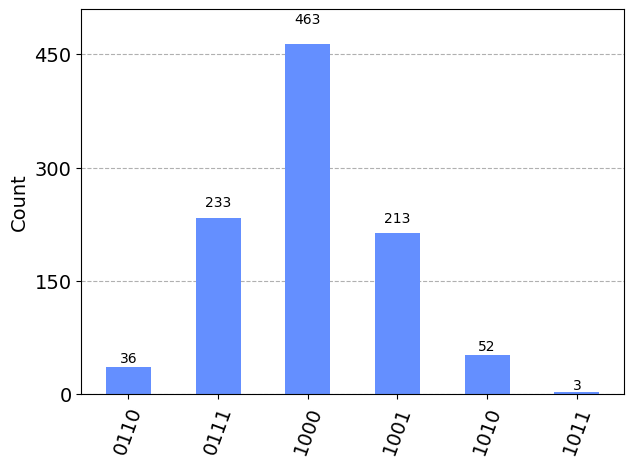

In [97]:
job = execute(spread_option, Aer.get_backend('qasm_simulator'), shots=1000)
counts = job.result().get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [98]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
# define overall multivariate problem

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
objectiveRegister = QuantumRegister(1, 'obj')
carryRegister = QuantumRegister(1, 'carry')
ancillaRegister = AncillaRegister(max(num_qubits_for_each_dimension, spread_objective.num_ancillas), 'ancilla')
optionAncillaRegister = AncillaRegister(spread_objective.num_ancillas, 'optionAncilla')
def swap_all(n):
    """Creates a circuit that swaps all qubits"""
    circuit = QuantumCircuit(n, name='SWAP_ALL')
    for i in range(n//2):
        circuit.swap(i, n-i-1)
    return circuit


spread_option = QuantumCircuit(carryRegister, firstRegister, secondRegister,objectiveRegister, ancillaRegister,  optionAncillaRegister)
spread_option.append(u, firstRegister[:-1] + secondRegister[:-1])
spread_option.append(circ, carryRegister[:] + firstRegister[:]+ secondRegister[:] + ancillaRegister[:])
spread_option.x(secondRegister[-1])
# swap = swap_all(num_qubits_for_each_dimension)
# spread_option.append(swap, secondRegister[:])
spread_option.append(spread_objective, secondRegister[:] + objectiveRegister[:] + optionAncillaRegister[:])

objective_index = num_qubits_for_each_dimension
print(objective_index)

spread_option.draw()

4


┌──────────────┐           
          carry: ─────────┤0             ├───────────
                 ┌───────┐│              │           
        first_0: ┤0      ├┤1             ├───────────
                 │       ││              │           
        first_1: ┤1      ├┤2             ├───────────
                 │       ││              │           
        first_2: ┤2      ├┤3             ├───────────
                 │       ││              │           
        first_3: ┤  P(X) ├┤4             ├───────────
                 │       ││              │     ┌────┐
       second_0: ┤3      ├┤5             ├─────┤0   ├
                 │       ││              │     │    │
       second_1: ┤4      ├┤6             ├─────┤1   ├
                 │       ││   subtractor │     │    │
       second_2: ┤5      ├┤7             ├─────┤2   ├
                 └───────┘│              │┌───┐│    │
       second_3: ─────────┤8             ├┤ X ├┤3   ├
                          │              │└───┘│    │
            obj: ─────────┤              ├─────┤4   ├
                          │              │     │    │
      ancilla_0: ─────────┤9             ├─────┤    ├
                          │              │     │    │
      ancilla_1: ─────────┤10            ├─────┤  F ├
                          │              │     │    │
      ancilla_2: ─────────┤11            ├─────┤    ├
                          │              │     │    │
      ancilla_3: ─────────┤12            ├─────┤    ├
                          └──────────────┘     │    │
optionAncilla_0: ──────────────────────────────┤5   ├
                                               │    │
optionAncilla_1: ──────────────────────────────┤6   ├
                                               │    │
optionAncilla_2: ──────────────────────────────┤7   ├
                                               │    │
optionAncilla_3: ──────────────────────────────┤8   ├
                                               └────┘

In [99]:
print(u.values)

[(0.0, 0.0), (0.0, 0.10036747395966694), (0.0, 0.20073494791933388), (0.0, 0.3011024218790008), (0.0, 0.40146989583866777), (0.0, 0.5018373697983347), (0.0, 0.6022048437580017), (0.0, 0.7025723177176686), (0.10036747395966694, 0.0), (0.10036747395966694, 0.10036747395966694), (0.10036747395966694, 0.20073494791933388), (0.10036747395966694, 0.3011024218790008), (0.10036747395966694, 0.40146989583866777), (0.10036747395966694, 0.5018373697983347), (0.10036747395966694, 0.6022048437580017), (0.10036747395966694, 0.7025723177176686), (0.20073494791933388, 0.0), (0.20073494791933388, 0.10036747395966694), (0.20073494791933388, 0.20073494791933388), (0.20073494791933388, 0.3011024218790008), (0.20073494791933388, 0.40146989583866777), (0.20073494791933388, 0.5018373697983347), (0.20073494791933388, 0.6022048437580017), (0.20073494791933388, 0.7025723177176686), (0.3011024218790008, 0.0), (0.3011024218790008, 0.10036747395966694), (0.3011024218790008, 0.20073494791933388), (0.301102421879000

In [100]:
# evaluate exact expected value
sum_values = np.array([v[0]-v[1] for v in u.values])
exact_value = np.dot(
    u.probabilities[sum_values >= strike_price],
    sum_values[sum_values >= strike_price] - strike_price,
)
print("exact expected value:\t%.5f" % exact_value)

exact expected value:	0.01936


In [107]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem
from qiskit_algorithms import IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

epsilon = 0.001
alpha = 0.005

problem = EstimationProblem(
    state_preparation=spread_option,
    objective_qubits=[9],
    post_processing=spread_objective.post_processing,
)
# construct amplitude estimation

# qi = QuantumInstance(backend=AerSimulator(), shots=200)
# ae = ModifiedIterativeAmplitudeEstimation(
#     epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
# result = ae.estimate(problem, shots=200)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 10000})
)
result = ae.estimate(problem)

In [108]:
print(result)

{   'alpha': 0.005,
    'circuit_results': None,
    'confidence_interval': (0.3261394872781022, 0.32707487386387785),
    'confidence_interval_processed': (0.4008748790836845, 0.4175484757524254),
    'epsilon_estimated': 0.00046769329288781636,
    'epsilon_estimated_processed': 0.008336798334370427,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.3083067432757767, 0.3409896420780066],
                              [0.3261394872781022, 0.32707487386387785]],
    'estimation': 0.32660718057099003,
    'estimation_processed': 0.409211677418055,
    'num_oracle_queries': 170000,
    'powers': [0, 0, 17],
    'ratios': [1.0, 35.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.09368943123608549, 0.09924546066631698],
                           [0.09673890826452108, 0.09689762922032888]]}


In [109]:
conf_int = (
    (np.array(result.confidence_interval_processed))
    / (2**(num_qubits_for_each_dimension)-1)
    * (high_ - low_)
)
print("Exact value:        \t%.4f" % exact_value)
print(
    "Estimated value:    \t%.4f"
    % ((result.estimation_processed) / (2**num_qubits_for_each_dimension - 1) * (high_ - low_))
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.0194
Estimated value:    	0.0192
Confidence interval:	[0.0188, 0.0196]
